# Image Classification Tutorial

In this tutorial, you'll build an image classifier from scratch and learn the fundamentals of visual recognition using PyTorch and CIFAR-10.

## Learning Objectives

By the end of this tutorial, you will:
1. Understand how images are represented as numerical arrays
2. Build and train a CNN for image classification
3. Evaluate model performance using standard metrics
4. Apply transfer learning to improve results

**Estimated time:** 15-20 minutes on CPU, 5-7 minutes on GPU

---

## Setup

First, let's import the necessary libraries and set up our environment.

**Core Libraries:**
- **numpy** — Numerical computing; we use it for array operations and data manipulation
- **matplotlib** — Plotting and visualization; essential for displaying images and training curves

**PyTorch Ecosystem:**
- **torch** — The core deep learning framework; provides tensors, autograd, and neural network primitives
- **torch.nn** — Neural network modules (Conv2d, Linear, BatchNorm, etc.)
- **torch.nn.functional** — Functional API for activations (ReLU, softmax) and loss functions
- **torch.optim** — Optimizers (Adam, SGD) that update model weights during training
- **torch.utils.data** — Data loading utilities (DataLoader, Dataset) for batching and shuffling

**Computer Vision:**
- **torchvision** — PyTorch's computer vision library with datasets, transforms, and pretrained models
- **torchvision.transforms** — Image preprocessing and augmentation (resize, normalize, flip, crop)
- **torchvision.models** — Pretrained architectures (ResNet, VGG, etc.) for transfer learning

**Evaluation & Visualization:**
- **sklearn.metrics** — Machine learning metrics; we use `confusion_matrix` for error analysis
- **seaborn** — Statistical visualization; makes beautiful heatmaps for confusion matrices

**Utilities:**
- **tqdm** — Progress bars for training loops; shows how far along each epoch is
- **time** — Timing utilities to measure training duration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# CIFAR-10 class names
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

Using device: cpu


### Helper Functions

Throughout this tutorial, we'll frequently need to visualize images. Rather than repeating the same plotting code, we define a reusable `show_images()` function.

**Why create helper functions?**
- **DRY principle** (Don't Repeat Yourself) — Write once, use everywhere
- **Handles edge cases** — Automatically denormalizes images, converts tensors to numpy, clips values
- **Consistent formatting** — Same style across all visualizations

This function handles the common annoyances of displaying PyTorch images:
- PyTorch uses **(C, H, W)** format, but matplotlib expects **(H, W, C)**
- Normalized images have negative values that don't display correctly
- We often want to show labels and predictions side-by-side

In [2]:
def show_images(images, labels=None, predictions=None, n_cols=5, figsize=(12, 4)):
    """Display a grid of images with optional labels and predictions."""
    n_images = len(images)
    n_rows = (n_images + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array(axes).flatten() if n_images > 1 else [axes]
    
    for idx, ax in enumerate(axes):
        if idx < n_images:
            img = images[idx]
            if torch.is_tensor(img):
                img = img.permute(1, 2, 0).numpy()
            # Denormalize if needed
            if img.min() < 0:
                img = img * np.array([0.247, 0.243, 0.262]) + np.array([0.491, 0.482, 0.447])
            img = np.clip(img, 0, 1)
            
            ax.imshow(img)
            
            if labels is not None and predictions is not None:
                true_label = CLASSES[labels[idx]] if isinstance(labels[idx], int) else labels[idx]
                pred_label = CLASSES[predictions[idx]] if isinstance(predictions[idx], int) else predictions[idx]
                color = 'green' if labels[idx] == predictions[idx] else 'red'
                ax.set_title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=8)
            elif labels is not None:
                label = CLASSES[labels[idx]] if isinstance(labels[idx], int) else labels[idx]
                ax.set_title(label, fontsize=9)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

---

## Part 1: Understanding Image Data

Before building a classifier, we need to understand what we're working with. Images are just numbers — understanding *how* they're represented is crucial for debugging and intuition.

### 1.1 Loading CIFAR-10

CIFAR-10 is a classic benchmark dataset:
- **60,000 images** (50k train, 10k test)
- **10 classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- **32x32 pixels**, RGB color
- Small enough to train quickly, complex enough to be challenging

**Why CIFAR-10?** It's the "MNIST of real images" — small enough to iterate quickly, but requires actual feature learning.

In [3]:
# Download CIFAR-10 (will cache locally after first download)
raw_train = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transforms.ToTensor()
)
raw_test = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transforms.ToTensor()
)

print(f"Training samples: {len(raw_train)}")
print(f"Test samples: {len(raw_test)}")
print(f"Number of classes: {len(CLASSES)}")

Training samples: 50000
Test samples: 10000
Number of classes: 10


### 1.2 Images as Tensors

An image is a 3D array: **(Channels, Height, Width)** in PyTorch.

- **Channels**: RGB = 3 channels (Red, Green, Blue)
- **Height & Width**: Spatial dimensions (32x32 for CIFAR-10)
- **Values**: Pixel intensities, typically 0-255 (uint8) or 0-1 (float)

> **Key insight**: A 32x32 RGB image has 32 × 32 × 3 = **3,072 numbers**. Classification means mapping these 3,072 numbers to one of 10 classes.

### 1.3 Visualizing the Data

Let's see what we're working with. CIFAR-10 images are tiny (32x32) — this matters for architecture design!

**Why does image size matter?**

1. **Pooling limits depth**: Each max-pooling layer halves spatial dimensions. With 32x32 input:
   - After 1 pool: 16x16
   - After 2 pools: 8x8
   - After 3 pools: 4x4
   - After 4 pools: 2x2 (almost no spatial info left!)
   
   Compare to ImageNet (224x224) which can handle 5+ pooling layers. This is why CIFAR-10 architectures tend to be shallower.

2. **Small receptive fields**: A 3x3 conv on a 32x32 image covers ~1% of the image. On 224x224, it covers ~0.02%. CIFAR-10 models "see" relatively more context per layer.

3. **Less fine detail**: At 32x32, subtle features (fur texture, eye details) are just a few pixels. The model must rely on coarse shape and color patterns.

4. **Faster iteration**: Small images = fast training. Great for learning and experimentation, but results don't always transfer to high-resolution tasks.

> **Practical implication**: Don't blindly copy ImageNet architectures (ResNet-50, VGG-16) for CIFAR-10. They're overbuilt for this resolution. Simpler, shallower networks often work better.

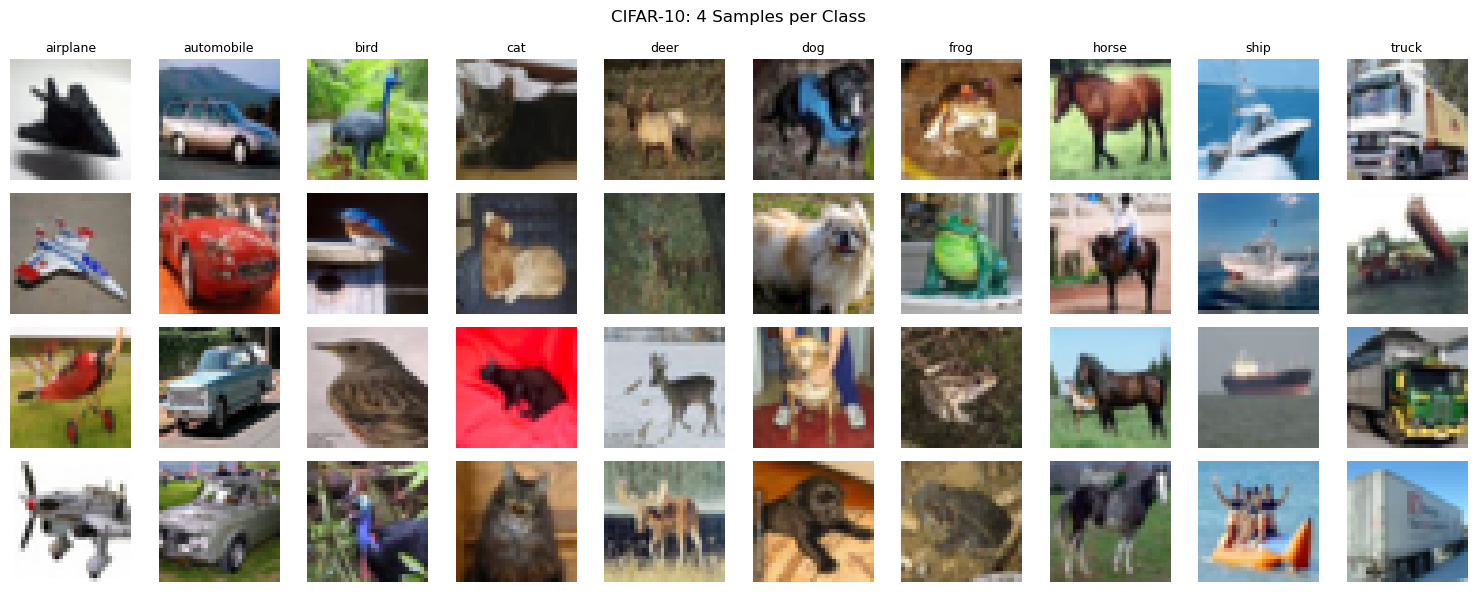

In [4]:
# Show 4 random samples from each class
fig, axes = plt.subplots(4, 10, figsize=(15, 6))

# Get indices for each class
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(raw_train):
    if len(class_indices[label]) < 4:
        class_indices[label].append(idx)
    if all(len(v) >= 4 for v in class_indices.values()):
        break

for class_idx in range(10):
    for row, idx in enumerate(class_indices[class_idx]):
        img, _ = raw_train[idx]
        axes[row, class_idx].imshow(img.permute(1, 2, 0))
        if row == 0:
            axes[row, class_idx].set_title(CLASSES[class_idx], fontsize=9)
        axes[row, class_idx].axis('off')

plt.suptitle("CIFAR-10: 4 Samples per Class", fontsize=12)
plt.tight_layout()
plt.show()

### 1.4 Why Normalization Matters

Neural networks learn better when inputs are standardized. We normalize images to have **mean ≈ 0** and **standard deviation ≈ 1**.

**Why does this help?**

Neural networks with standard weight initialization (like Xavier or Kaiming) assume inputs have zero mean and unit variance. When you feed unnormalized data, the early layers produce activations with unexpected magnitudes, causing:
- **Unstable gradients** — large input values lead to large gradients, making training erratic
- **Slower convergence** — the optimizer struggles to find a good path through the loss landscape
- **Learning rate sensitivity** — you need different learning rates for features at different scales

We compute mean and std *per channel* across the training set, then apply the transformation:

```
normalized_pixel = (pixel - mean) / std
```

In the cell below, we visualize what normalization does to an image:

| Panel | What It Shows |
|-------|---------------|
| **Left — Raw Image** | Pixel values in [0, 1] after `ToTensor()`. This is how the image looks naturally. |
| **Middle — Normalized** | After subtracting mean and dividing by std, values shift to roughly [-2, +2]. We rescale for display only — matplotlib can't render negative values. |
| **Right — Histogram** | The blue (raw) distribution is clustered in [0, 1]. The orange (normalized) distribution is centered at 0 with unit-scale spread. |

**Key properties after normalization:**

| Property | Raw [0,1] | Normalized |
|----------|-----------|------------|
| Mean | ~0.5 | ~0 |
| Range | 0 to 1 | Typically -2 to +2 |
| Gradient scale | Varies with input | Consistent |
| Weight init compatibility | Poor | Good |

**A Common Mistake**

Forgetting to apply the *same* normalization at test time. If you train with CIFAR-10 stats but forget to normalize test images (or use different stats), your model sees a completely different input distribution and performs poorly.

In [5]:
def compute_mean_std(dataset):
    """Compute per-channel mean and std for a dataset."""
    loader = DataLoader(dataset, batch_size=1000, shuffle=False)
    
    mean = torch.zeros(3)
    std = torch.zeros(3)
    n_samples = 0
    
    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, 3, -1)  # (B, C, H*W)
        mean += images.mean(dim=[0, 2]) * batch_size
        std += images.std(dim=[0, 2]) * batch_size
        n_samples += batch_size
    
    mean /= n_samples
    std /= n_samples
    return mean, std

mean, std = compute_mean_std(raw_train)
print(f"CIFAR-10 Mean (per channel): {mean}")
print(f"CIFAR-10 Std (per channel): {std}")
print("\nStandard values used in practice:")
print("  mean = [0.4914, 0.4822, 0.4465]")
print("  std = [0.2470, 0.2435, 0.2616]")

CIFAR-10 Mean (per channel): tensor([0.4914, 0.4822, 0.4465])
CIFAR-10 Std (per channel): tensor([0.2470, 0.2434, 0.2615])

Standard values used in practice:
  mean = [0.4914, 0.4822, 0.4465]
  std = [0.2470, 0.2435, 0.2616]


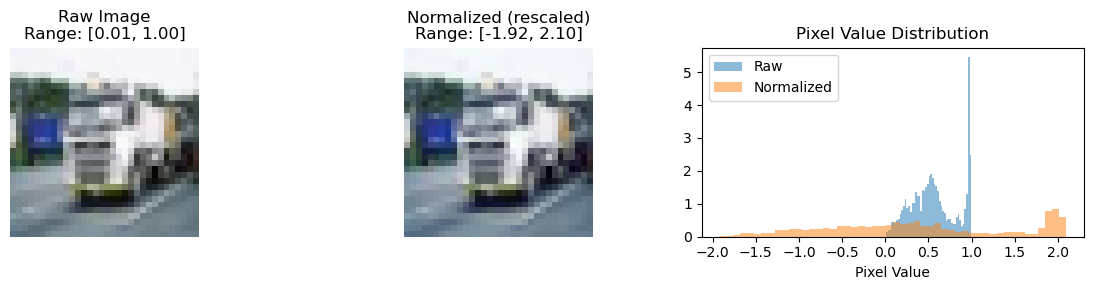

In [6]:
# Visualize effect of normalization
image, label = raw_train[1000]

# Normalize
mean_tensor = torch.tensor([0.491, 0.482, 0.447]).view(3, 1, 1)
std_tensor = torch.tensor([0.247, 0.243, 0.262]).view(3, 1, 1)
normalized = (image - mean_tensor) / std_tensor

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Raw image
axes[0].imshow(image.permute(1, 2, 0))
axes[0].set_title(f"Raw Image\nRange: [{image.min():.2f}, {image.max():.2f}]")
axes[0].axis('off')

# Normalized (rescaled for display)
norm_display = normalized.permute(1, 2, 0).numpy()
norm_display = (norm_display - norm_display.min()) / (norm_display.max() - norm_display.min())
axes[1].imshow(norm_display)
axes[1].set_title(f"Normalized (rescaled)\nRange: [{normalized.min():.2f}, {normalized.max():.2f}]")
axes[1].axis('off')

# Histogram of pixel values
axes[2].hist(image.flatten().numpy(), bins=50, alpha=0.5, label='Raw', density=True)
axes[2].hist(normalized.flatten().numpy(), bins=50, alpha=0.5, label='Normalized', density=True)
axes[2].set_title("Pixel Value Distribution")
axes[2].legend()
axes[2].set_xlabel("Pixel Value")

plt.tight_layout()
plt.show()

### 1.5 Preparing Data with Transforms

PyTorch's `transforms` module lets us build preprocessing pipelines. The cell above shows **391 training batches** and **79 test batches** — with batch size 128, that's 50,048 training samples (some padding) processed per epoch.

For training, we add **data augmentation** — random modifications that help the model generalize:

**Our Transform Pipeline:**

```python
train_transform = Compose([
    RandomHorizontalFlip(p=0.5),  # 50% chance to mirror image
    RandomCrop(32, padding=4),     # Pad by 4, then crop random 32×32
    ToTensor(),                    # Convert to tensor, scale to [0,1]
    Normalize(mean, std)           # Center and scale
])
```

**Common augmentations for classification:**
- Random horizontal flip (a flipped cat is still a cat)
- Random crop with padding (slight position shifts)
- Color jitter (lighting variations)

> **Critical**: We only augment the *training* set. Test data uses only normalization — no randomness — so results are reproducible.

In [7]:
# Define transforms with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Simulate lighting variation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.491, 0.482, 0.447], 
                        std=[0.247, 0.243, 0.262])
])

# Test transform: no augmentation, just normalize
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.491, 0.482, 0.447], 
                        std=[0.247, 0.243, 0.262])
])

# Create datasets with transforms
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

# Create data loaders
# Note: num_workers=0 for cross-platform compatibility (macOS/Windows)
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 391
Test batches: 79


### Why Data Augmentation Works

Data augmentation is one of the most powerful techniques for improving model generalization, especially when you have limited training data. The core idea is simple: **artificially expand your dataset by creating modified versions of existing images**.

**The Overfitting Problem**

Neural networks are powerful function approximators — sometimes *too* powerful. Given enough capacity, a CNN can memorize the training set instead of learning generalizable patterns. When this happens:
- Training accuracy approaches 100%
- Test accuracy plateaus or drops
- The model fails on slightly different inputs (new lighting, angles, positions)

**How Augmentation Helps**

Augmentation combats overfitting through two mechanisms:

1. **Implicit regularization**: By showing the model many variations of each image, we prevent it from latching onto spurious details (like "cats are always in the center" or "dogs always face left"). The model is forced to learn the *essence* of each class.

2. **Domain coverage**: Real-world images vary in ways your training set may not capture. Augmentation simulates this variation — different crops approximate different camera positions, flips simulate mirror images, color jitter simulates lighting changes.

**Common Augmentation Techniques**

| Augmentation | What It Does | Use Case |
|--------------|--------------|----------|
| **Horizontal Flip** | Mirror the image left-to-right | Most natural images (not text!) |
| **Random Crop** | Take a random sub-region | Simulates different camera positions |
| **ColorJitter** | Randomly adjust brightness, contrast, saturation, hue | Simulates different lighting conditions |
| **Rotation** | Rotate by small angles | Objects that can appear at any angle |
| **Gaussian Blur** | Slightly blur the image | Simulates focus variation |

**Choosing Augmentations Wisely**

Not all augmentations are appropriate for all tasks:

- **Horizontal flip** works for most natural images, but NOT for text recognition (a flipped "b" becomes "d") or tasks where left/right matters
- **Vertical flip** rarely makes sense for natural images (upside-down cats are rare!)
- **ColorJitter** is powerful but be careful with hue shifts — a red apple turning green changes its meaning
- **Rotation** should be limited for CIFAR-10 — extreme rotations create unnatural images

**Our Augmentation Pipeline**

We use a moderate augmentation strategy that balances variety with realism:
```python
transforms.RandomHorizontalFlip(p=0.5)      # 50% chance to flip
transforms.RandomCrop(32, padding=4)        # Random position within 4px
transforms.ColorJitter(brightness=0.2, contrast=0.2)  # Subtle lighting variation
```

The visualization below shows each augmentation applied individually so you can see exactly what each one does.

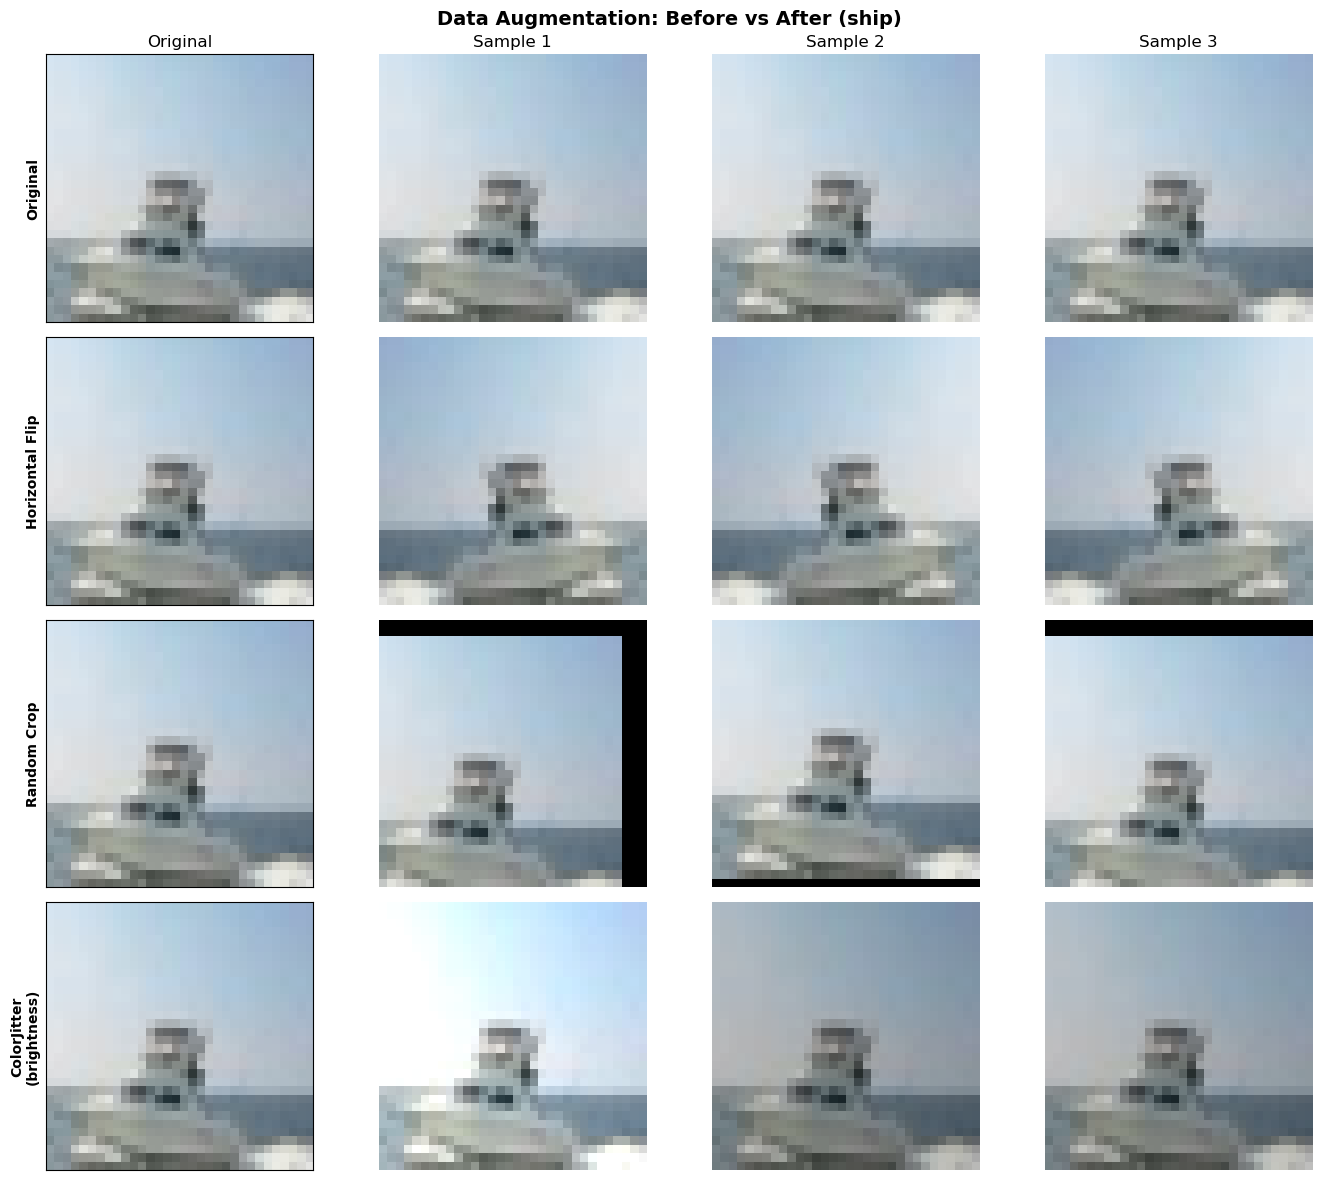

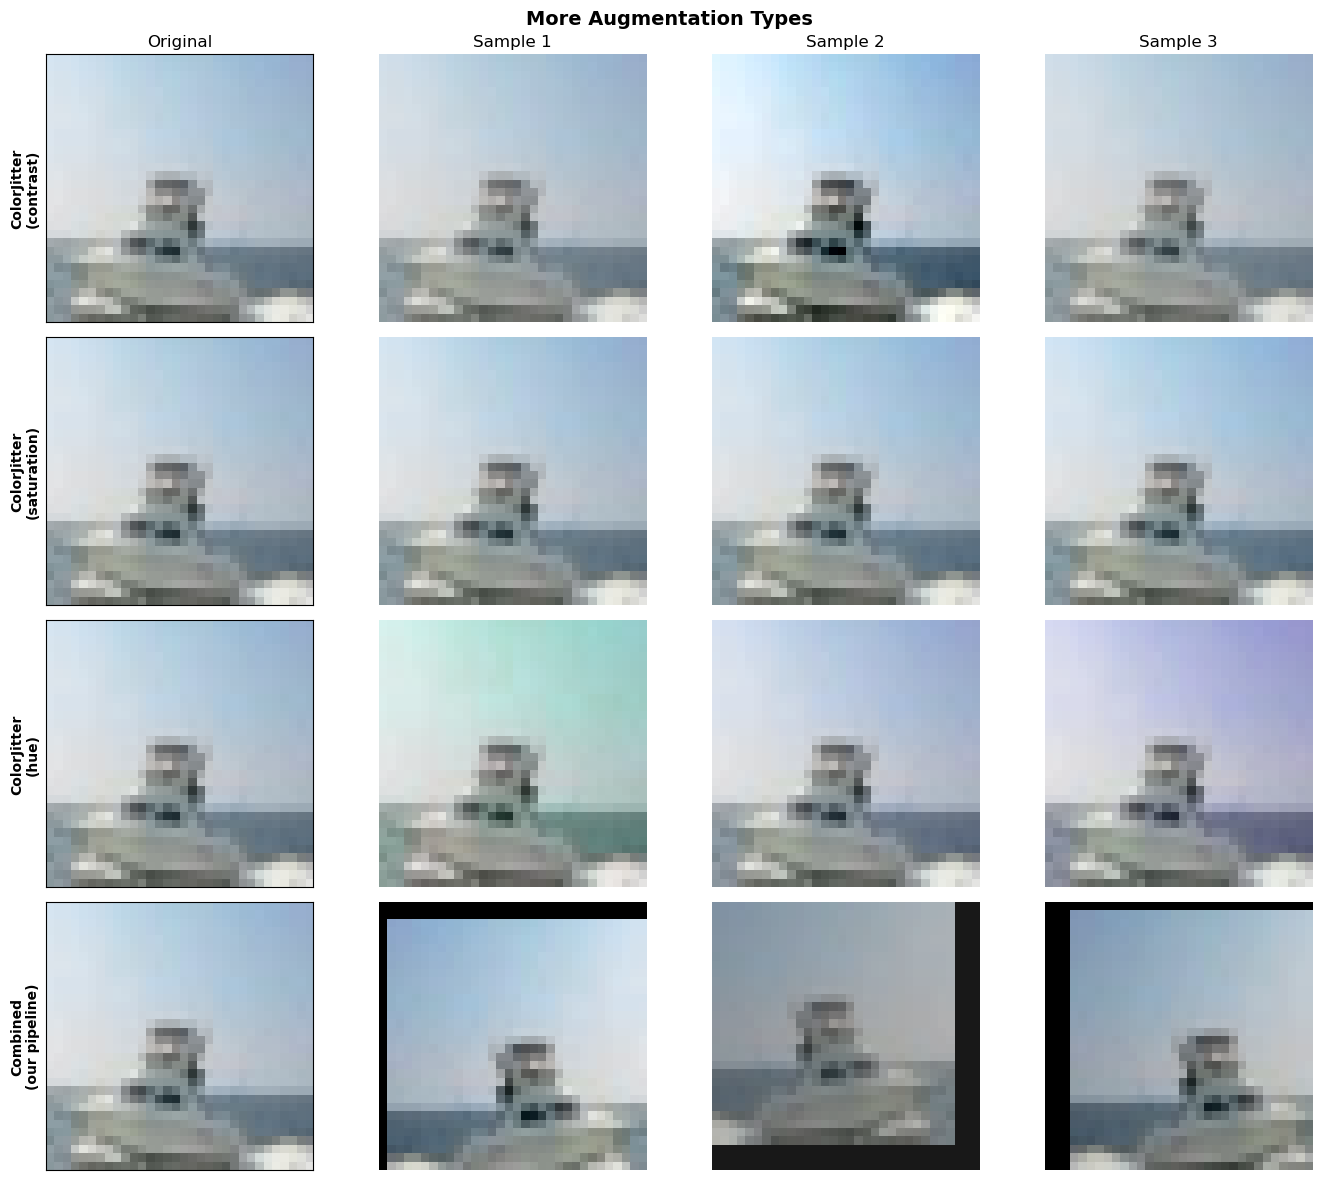

In [8]:
# Visualize each augmentation type with before/after comparison
fig, axes = plt.subplots(4, 4, figsize=(14, 12))

# Get a raw image for demonstration
raw_img, label = raw_train[100]
original = raw_img.permute(1, 2, 0).numpy()

# Define individual augmentations to demonstrate
augmentations = [
    ("Original", None),
    ("Horizontal Flip", transforms.RandomHorizontalFlip(p=1.0)),
    ("Random Crop", transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor()
    ])),
    ("ColorJitter\n(brightness)", transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.4),
        transforms.ToTensor()
    ])),
    ("ColorJitter\n(contrast)", transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(contrast=0.4),
        transforms.ToTensor()
    ])),
    ("ColorJitter\n(saturation)", transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(saturation=0.4),
        transforms.ToTensor()
    ])),
    ("ColorJitter\n(hue)", transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(hue=0.1),
        transforms.ToTensor()
    ])),
    ("Combined\n(our pipeline)", transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor()
    ])),
]

# Show original in first column, augmented versions (3 samples each) in remaining columns
for row, (name, aug) in enumerate(augmentations[:4]):
    # Show original
    axes[row, 0].imshow(original)
    axes[row, 0].set_title("Original" if row == 0 else "")
    axes[row, 0].set_ylabel(name, fontsize=10, fontweight='bold')
    axes[row, 0].set_xticks([])
    axes[row, 0].set_yticks([])
    
    # Show 3 augmented versions
    for col in range(1, 4):
        if aug is None:
            img = original
        else:
            augmented = aug(raw_img)
            img = augmented.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Sample {col}" if row == 0 else "")
        axes[row, col].axis('off')

plt.suptitle(f"Data Augmentation: Before vs After ({CLASSES[label]})", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show more augmentation types in second figure
fig2, axes2 = plt.subplots(4, 4, figsize=(14, 12))

for row, (name, aug) in enumerate(augmentations[4:]):
    # Show original
    axes2[row, 0].imshow(original)
    axes2[row, 0].set_ylabel(name, fontsize=10, fontweight='bold')
    axes2[row, 0].set_xticks([])
    axes2[row, 0].set_yticks([])
    
    # Show 3 augmented versions
    for col in range(1, 4):
        if aug is None:
            img = original
        else:
            augmented = aug(raw_img)
            img = augmented.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
        axes2[row, col].imshow(img)
        axes2[row, col].axis('off')

# Add column headers
axes2[0, 0].set_title("Original")
for col in range(1, 4):
    axes2[0, col].set_title(f"Sample {col}")

plt.suptitle("More Augmentation Types", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## Part 2: Building a CNN

### 2.1 Why Convolutional Neural Networks?

A fully-connected network treating each pixel independently would need:
- Input: 32 × 32 × 3 = 3,072 features
- First hidden layer (256 neurons): 3,072 × 256 = **786,432 parameters**

This is wasteful and ignores spatial structure. **CNNs exploit two key insights:**

1. **Local connectivity**: A pixel's meaning depends on its neighbors (edges, textures)
2. **Translation invariance**: A cat in the top-left is the same as a cat in the bottom-right

**The convolution operation:**
- Slide a small filter (e.g., 3×3) across the image
- At each position, compute dot product between filter and image patch
- Same filter weights used everywhere → parameter sharing

### 2.2 CNN Building Blocks

A CNN is built from these core layers:

| Layer | Purpose | Effect on Shape |
|-------|---------|----------------|
| **Conv2d** | Detect local patterns | (C_in, H, W) → (C_out, H', W') |
| **ReLU** | Add non-linearity | Shape unchanged |
| **MaxPool2d** | Downsample, add invariance | Reduces H, W by factor |
| **BatchNorm2d** | Stabilize training | Shape unchanged |
| **Flatten** | Prepare for classification | (C, H, W) → (C×H×W,) |
| **Linear** | Final classification | (features,) → (classes,) |

**The Cell Below: Layer-by-Layer Exploration**

The following code shows exactly how tensor shapes change through each layer. Key observations:

1. **Conv2d with padding=1**: Input (3, 32, 32) → Output (16, 32, 32). The spatial size is *preserved* because padding=1 compensates for the 3×3 kernel.

2. **MaxPool2d(2×2)**: Halves spatial dimensions: 32×32 → 16×16. This is crucial for building hierarchical features — each subsequent layer "sees" a larger portion of the original image.

3. **Flatten**: Collapses spatial dimensions into a single vector. 16 channels × 16 × 16 spatial = 4,096 numbers. This is where we transition from "image understanding" to "classification."

4. **Linear**: Maps features to class scores. 4,096 → 10 means each of the 10 output neurons is a weighted sum of all 4,096 features.

In [9]:
# Interactive exploration of each layer
dummy_input = torch.randn(1, 3, 32, 32)  # (batch, channels, height, width)
print(f"Input shape: {dummy_input.shape}")

# Conv2d: Extract features
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
out = conv(dummy_input)
print(f"\nAfter Conv2d(3→16, kernel=3, padding=1): {out.shape}")
print(f"  - 16 different 3×3 filters")
print(f"  - padding=1 preserves spatial size")

# ReLU: Non-linearity
out = F.relu(out)
print(f"\nAfter ReLU: {out.shape} (same shape, negative values → 0)")

# BatchNorm: Normalize activations
bn = nn.BatchNorm2d(16)
out = bn(out)
print(f"\nAfter BatchNorm2d: {out.shape} (same shape, normalized)")

# MaxPool2d: Downsample
pool = nn.MaxPool2d(kernel_size=2, stride=2)
out = pool(out)
print(f"\nAfter MaxPool2d(2×2): {out.shape}")
print(f"  - Spatial dimensions halved: 32→16")
print(f"  - Takes max in each 2×2 region")

# Flatten: Prepare for classifier
out_flat = out.view(out.size(0), -1)
print(f"\nAfter Flatten: {out_flat.shape}")
print(f"  - 16 channels × 16 × 16 = 4,096 features")

# Linear: Classify
fc = nn.Linear(4096, 10)
out_final = fc(out_flat)
print(f"\nAfter Linear(4096→10): {out_final.shape}")
print(f"  - 10 outputs, one per class")

Input shape: torch.Size([1, 3, 32, 32])

After Conv2d(3→16, kernel=3, padding=1): torch.Size([1, 16, 32, 32])
  - 16 different 3×3 filters
  - padding=1 preserves spatial size

After ReLU: torch.Size([1, 16, 32, 32]) (same shape, negative values → 0)

After BatchNorm2d: torch.Size([1, 16, 32, 32]) (same shape, normalized)

After MaxPool2d(2×2): torch.Size([1, 16, 16, 16])
  - Spatial dimensions halved: 32→16
  - Takes max in each 2×2 region

After Flatten: torch.Size([1, 4096])
  - 16 channels × 16 × 16 = 4,096 features

After Linear(4096→10): torch.Size([1, 10])
  - 10 outputs, one per class


### 2.3 Our CNN Architecture

We'll build a simple but effective CNN for CIFAR-10:

```
Input: (3, 32, 32)
    ↓
Conv Block 1: 3 → 32 channels, 32×32 → 16×16
    ↓
Conv Block 2: 32 → 64 channels, 16×16 → 8×8
    ↓
Conv Block 3: 64 → 128 channels, 8×8 → 4×4
    ↓
Flatten: 128 × 4 × 4 = 2,048 features
    ↓
FC: 2,048 → 256 → 10
    ↓
Output: 10 class scores
```

**Understanding the Parameter Count**

The model has **~620,000 parameters**. Where do they come from?

| Layer | Calculation | Parameters |
|-------|-------------|------------|
| Conv1 | 3×32×3×3 + 32 bias | 896 |
| Conv2 | 32×64×3×3 + 64 bias | 18,496 |
| Conv3 | 64×128×3×3 + 128 bias | 73,856 |
| FC1 | 2048×256 + 256 bias | 524,544 |
| FC2 | 256×10 + 10 bias | 2,570 |
| BatchNorm (×3) | 2 params per channel | 448 |
| **Total** | | **~620,810** |

Notice that **FC1 dominates** — it has 85% of all parameters! This is common in CNNs: the transition from spatial features to classification requires many weights. Modern architectures use global average pooling to reduce this.

In [10]:
class SimpleCNN(nn.Module):
    """
    A simple CNN for CIFAR-10 classification.
    
    Architecture: 3 conv blocks + 2 FC layers
    Total parameters: ~300k (trainable on CPU)
    """
    
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Conv Block 1: 3 → 32 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Conv Block 2: 32 → 64 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Conv Block 3: 64 → 128 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling (reused)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Classifier
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Block 1: 32x32 → 16x16
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Block 2: 16x16 → 8x8
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Block 3: 8x8 → 4x4
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Classifier
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Create model and inspect
model = SimpleCNN().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:\n{model}")

Total parameters: 620,810
Trainable parameters: 620,810

Model architecture:
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### 2.4 What Does the CNN "See"?

One of the most important skills in deep learning is developing **intuition** for what your model is actually learning. CNNs are often called "black boxes," but we can peek inside by visualizing **feature maps** — the intermediate outputs after each convolutional layer.

**What is a Feature Map?**

When an image passes through a convolutional layer, each filter produces a 2D output called a feature map (or activation map). If a layer has 32 filters, it produces 32 feature maps. Each feature map highlights *where* in the image a particular pattern was detected.

Think of it this way:
- **Input**: A 32×32×3 RGB image (3 channels)
- **After Conv1 (32 filters)**: 32×32×32 tensor (32 feature maps)
- Each feature map answers: "Where does this filter's pattern appear in the image?"

**The Hierarchy of Features**

CNNs learn a **hierarchical representation** of images. This is perhaps the most important insight about how deep learning works for vision:

| Layer Depth | What It Detects | Spatial Resolution | Example Patterns |
|-------------|-----------------|-------------------|------------------|
| **Early layers** (Conv1) | Low-level features | High (32×32) | Edges, colors, simple textures |
| **Middle layers** (Conv2) | Mid-level features | Medium (16×16) | Corners, curves, texture combinations |
| **Deep layers** (Conv3+) | High-level features | Low (8×8, 4×4) | Object parts, semantic patterns |

This hierarchy emerges naturally through training — we don't program it explicitly. The network discovers that detecting edges first, then combining edges into shapes, then combining shapes into objects, is an efficient strategy.

**Why Does This Hierarchy Form?**

1. **Receptive field growth**: Early layers see small patches (3×3). After pooling and stacking convolutions, later layers "see" larger regions of the original image. A neuron in Conv3 might have an effective receptive field covering half the image.

2. **Compositionality**: Complex patterns are built from simpler ones. An "eye" detector in a later layer might combine edge detectors (for the outline), texture detectors (for the iris), and color detectors (for the pupil) from earlier layers.

3. **Gradient flow**: During backpropagation, gradients flow from the classification loss back through the network. Early layers receive gradients that say "detect features useful for the layers above," naturally creating a hierarchy.

**How to Read Feature Map Visualizations**

In the visualization below, we show the first 8 channels (out of 32 or 64) at each stage:

- **Bright regions** = high activation = the filter's pattern was detected there
- **Dark regions** = low/no activation = the pattern is absent
- **Different channels** = different patterns being detected

What to look for:
- **Conv1 outputs**: Should show edge-like responses — some channels respond to horizontal edges, others to vertical, others to specific colors
- **After pooling**: Same information but at lower resolution (16×16 instead of 32×32)
- **Conv2 outputs**: More complex patterns — combinations of edges, texture-like responses
- **Deeper layers**: Increasingly abstract — harder to interpret visually, but encoding semantic information

**A Critical Insight: Distributed Representations**

No single feature map encodes "this is a cat." Instead, the information is **distributed** across many channels. The classification happens when the final fully-connected layers combine all these feature maps into a single decision.

This distributed nature makes CNNs robust — if one feature is occluded or noisy, other features can compensate.

**Practical Applications of Feature Visualization**

Understanding feature maps isn't just academic — it's a debugging tool:

1. **Dead filters**: If a feature map is all zeros, that filter learned nothing useful (often a sign of dying ReLU or poor initialization)
2. **Redundant filters**: If two feature maps look identical, you might have unnecessary capacity
3. **Unexpected patterns**: If early layers show high-level patterns (faces, objects), something is wrong — this suggests the model might be memorizing rather than generalizing

In the cell below, we extract feature maps from our untrained model. The patterns will look somewhat random at this stage. After training, you could re-run this visualization to see how the learned features become more structured and meaningful.

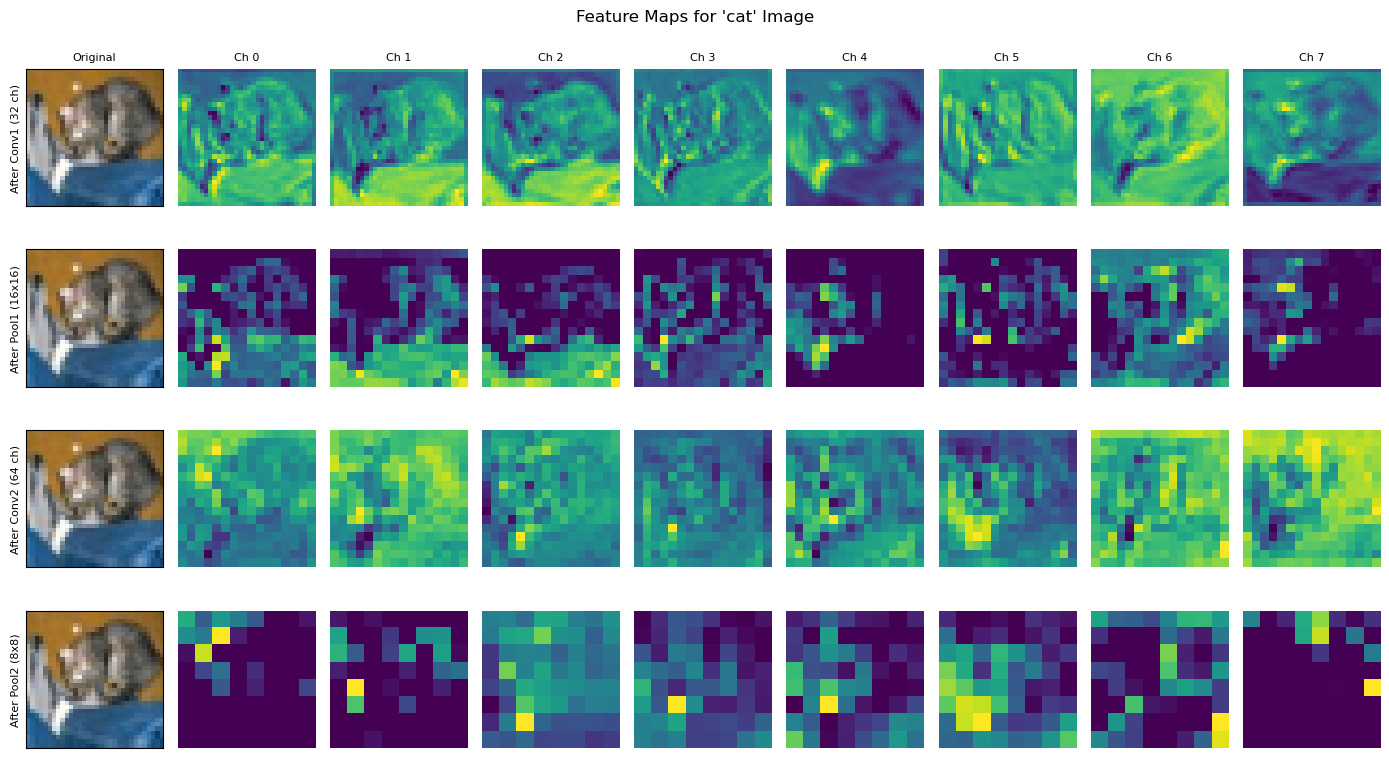

In [11]:
# Get a sample image
sample_img, sample_label = test_dataset[0]
sample_img_batch = sample_img.unsqueeze(0).to(device)

# Extract feature maps at each layer
model.eval()
feature_maps = []
x = sample_img_batch

with torch.no_grad():
    # Block 1
    x = model.conv1(x)
    feature_maps.append(('After Conv1 (32 ch)', x.cpu()))
    x = model.bn1(x)
    x = F.relu(x)
    x = model.pool(x)
    feature_maps.append(('After Pool1 (16x16)', x.cpu()))
    
    # Block 2  
    x = model.conv2(x)
    feature_maps.append(('After Conv2 (64 ch)', x.cpu()))
    x = model.bn2(x)
    x = F.relu(x)
    x = model.pool(x)
    feature_maps.append(('After Pool2 (8x8)', x.cpu()))

# Visualize first 8 channels from each stage
fig, axes = plt.subplots(len(feature_maps), 9, figsize=(14, len(feature_maps)*2))

for row, (title, fmap) in enumerate(feature_maps):
    # Original image in first column
    orig = sample_img.cpu()
    orig = orig * torch.tensor([0.247, 0.243, 0.262]).view(3,1,1) + torch.tensor([0.491, 0.482, 0.447]).view(3,1,1)
    axes[row, 0].imshow(orig.permute(1,2,0).clip(0,1))
    axes[row, 0].set_ylabel(title, fontsize=8)
    axes[row, 0].set_xticks([])
    axes[row, 0].set_yticks([])
    
    # Feature maps
    for ch in range(8):
        axes[row, ch+1].imshow(fmap[0, ch], cmap='viridis')
        axes[row, ch+1].axis('off')
        if row == 0:
            axes[row, ch+1].set_title(f'Ch {ch}', fontsize=8)

axes[0, 0].set_title('Original', fontsize=8)
plt.suptitle(f"Feature Maps for '{CLASSES[sample_label]}' Image", fontsize=12)
plt.tight_layout()
plt.show()

---

## Part 3: Training the Model

Now that we've built our CNN, let's train it! Training involves showing the model thousands of images, computing how wrong its predictions are, and adjusting the weights to improve.

### 3.1 The Loss Function: Cross-Entropy

The **loss function** measures how wrong our predictions are. For classification, we use **Cross-Entropy Loss**:

$$\mathcal{L} = -\log(\hat{y}_{true})$$

Where $\hat{y}_{true}$ is the predicted probability for the correct class.

**Intuition**: Cross-entropy penalizes confident wrong predictions heavily. If the true class is "cat" and you predict 0.01 probability for cat, the loss is $-\log(0.01) = 4.6$. But if you predict 0.99, the loss is only $-\log(0.99) = 0.01$.

**What the Numbers Mean**

The demonstration below shows four scenarios. Here's how to interpret each:

| Scenario | Prob for True Class | Loss | Interpretation |
|----------|-------------------|------|----------------|
| Confident & Correct | 99.96% | 0.0004 | Almost perfect — model is certain and right |
| Unsure but Correct | 15.5% | 1.87 | Model gives true class only slight edge over others |
| Confident & WRONG | 0.004% | 10.0 | Catastrophic — model is certain but completely wrong |
| Completely Unsure | 10% | 2.30 | Uniform probability = $-\log(0.1) = \ln(10)$ |

**Key insights:**
- The loss for "confident & wrong" (10.0) is **5,000× larger** than "confident & correct" (0.002). This asymmetry drives the model to avoid confident mistakes.
- "Completely unsure" (loss = 2.30) is equivalent to random guessing among 10 classes. This is the *baseline* a model should beat.
- The loss for "unsure but correct" (1.87) shows that being right isn't enough — the model should also be *confident* when right.

In PyTorch, `nn.CrossEntropyLoss` applies softmax internally, so you pass raw logits (unnormalized scores), not probabilities.

In [12]:
# Demonstrate cross-entropy loss behavior
true_label = torch.tensor([0])  # True class is 0

scenarios = [
    ("Confident & Correct", torch.tensor([[10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])),
    ("Unsure but Correct", torch.tensor([[1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])),
    ("Confident & WRONG", torch.tensor([[0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])),
    ("Completely Unsure", torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])),
]

criterion = nn.CrossEntropyLoss()

print("Loss for different prediction scenarios (true class = 0):\n")
for name, logits in scenarios:
    loss = criterion(logits, true_label)
    probs = F.softmax(logits, dim=1)
    print(f"{name}:")
    print(f"  Prob for class 0: {probs[0, 0]:.4f}")
    print(f"  Loss: {loss.item():.4f}\n")

Loss for different prediction scenarios (true class = 0):

Confident & Correct:
  Prob for class 0: 0.9996
  Loss: 0.0004

Unsure but Correct:
  Prob for class 0: 0.1548
  Loss: 1.8654

Confident & WRONG:
  Prob for class 0: 0.0000
  Loss: 10.0004

Completely Unsure:
  Prob for class 0: 0.1000
  Loss: 2.3026



### 3.2 The Optimizer and Learning Rate

The **optimizer** updates model weights to reduce the loss. We use **Adam** — a robust default choice:
- Adapts learning rate per-parameter (faster convergence)
- Maintains momentum (smooths out noisy gradients)
- Works well "out of the box" with default settings

**Learning Rate: The Most Important Hyperparameter**

The learning rate controls how big each weight update is:
- **Too high**: Training diverges, loss explodes
- **Too low**: Training is slow, may get stuck in local minima
- **Just right**: Smooth convergence to good solution

**Learning Rate Schedulers**

In practice, it often helps to *decrease* the learning rate during training:

| Scheduler | Strategy | Use Case |
|-----------|----------|----------|
| **StepLR** | Multiply LR by gamma every N epochs | Simple, predictable decay |
| **ReduceLROnPlateau** | Reduce when metric stops improving | Adaptive, watches validation loss |
| **CosineAnnealingLR** | Smoothly decrease following cosine curve | Popular in modern training |
| **OneCycleLR** | Increase then decrease in one cycle | Fast convergence, good results |

```python
# Example: Reduce LR by 10x every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Example: Reduce when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
```

For this tutorial, we'll use a constant learning rate for simplicity. In the project template, you can experiment with schedulers.

In [13]:
# Setup loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Parameters being optimized: {len(list(model.parameters()))} tensors")

Optimizer: Adam
Learning rate: 0.001
Parameters being optimized: 16 tensors


### 3.3 The Training Loop

Training follows a simple pattern:

```
For each epoch:
    For each batch:
        1. Forward pass: predictions = model(images)
        2. Compute loss: loss = criterion(predictions, labels)
        3. Backward pass: loss.backward() → compute gradients
        4. Update weights: optimizer.step()
        5. Zero gradients: optimizer.zero_grad()
```

**Important**: Always zero gradients before backward pass! PyTorch accumulates gradients by default.

In [14]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch, return average loss and accuracy."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """Evaluate on validation/test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

### 3.4 Let's Train!

We'll train for 10 epochs. On CPU, this takes about 10-12 minutes. On GPU, under 2 minutes.

**What to Watch For During Training**

As the model trains, observe these patterns:

1. **Epoch 1**: Accuracy around 40-45%. The model is learning basic features (edges, colors) that provide *some* class separation, but it's still largely guessing.

2. **Epochs 2-4**: Rapid improvement to 55-65%. The model learns more discriminative features — shapes, textures, and simple patterns that distinguish vehicles from animals.

3. **Epochs 5-7**: Slower progress, reaching 65-70%. The "easy" gains are done; now the model refines subtle distinctions.

4. **Epochs 8-10**: Plateauing around 70-75%. Further improvements become marginal. The model has learned what it can at this capacity and resolution.

**Signs of Trouble**

- **Loss increases**: Learning rate too high, or bug in code
- **Val accuracy drops while train accuracy rises**: Overfitting
- **Both metrics stuck at low values**: Model not learning (check data, architecture)
- **NaN loss**: Numerical instability (reduce learning rate, check for bugs)

In [15]:
# Training configuration
NUM_EPOCHS = 10
criterion = nn.CrossEntropyLoss()  # Define here to avoid dependency issues
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Reset model for fresh training
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Starting training...")
print(f"Device: {device}")
print(f"Training samples: {len(train_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Batches per epoch: {len(train_loader)}")
print("-" * 60)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS} ({epoch_time:.1f}s) | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

total_time = time.time() - start_time
print("-" * 60)
print(f"Training complete in {total_time:.1f}s")
print(f"Best validation accuracy: {max(history['val_acc']):.2f}%")

Starting training...
Device: cpu
Training samples: 50000
Batch size: 128
Batches per epoch: 391
------------------------------------------------------------
Epoch  1/10 (51.3s) | Train Loss: 1.6089, Acc: 40.83% | Val Loss: 1.2005, Acc: 56.45%
Epoch  2/10 (52.4s) | Train Loss: 1.2678, Acc: 54.21% | Val Loss: 1.0378, Acc: 62.36%
Epoch  3/10 (54.6s) | Train Loss: 1.1510, Acc: 58.77% | Val Loss: 0.9243, Acc: 67.31%
Epoch  4/10 (53.8s) | Train Loss: 1.0751, Acc: 62.00% | Val Loss: 0.8920, Acc: 68.39%
Epoch  5/10 (53.3s) | Train Loss: 1.0124, Acc: 64.51% | Val Loss: 0.8451, Acc: 70.04%
Epoch  6/10 (54.6s) | Train Loss: 0.9659, Acc: 66.08% | Val Loss: 0.7684, Acc: 73.16%
Epoch  7/10 (53.7s) | Train Loss: 0.9396, Acc: 67.64% | Val Loss: 0.7394, Acc: 73.96%
Epoch  8/10 (54.5s) | Train Loss: 0.8982, Acc: 68.85% | Val Loss: 0.7045, Acc: 75.81%
Epoch  9/10 (54.4s) | Train Loss: 0.8698, Acc: 69.63% | Val Loss: 0.7248, Acc: 74.19%
Epoch 10/10 (54.5s) | Train Loss: 0.8426, Acc: 70.69% | Val Loss: 0.7

### 3.5 Reading Training Curves

Training curves tell a story. Learn to read them!

**What to Expect**

The training output above reveals several important patterns:

1. **Rapid early progress**: Accuracy jumps significantly in the first few epochs as the model learns basic patterns
2. **Diminishing returns**: Improvements slow down as the "easy" patterns are learned
3. **Train-val gap**: Training accuracy is typically higher than validation — this is normal

**Detecting Overfitting**

Overfitting occurs when your model memorizes the training data instead of learning generalizable patterns. Watch for these warning signs:

| Symptom | What It Looks Like | What To Do |
|---------|-------------------|------------|
| **Diverging curves** | Train loss keeps dropping, val loss starts increasing | Stop training, add regularization |
| **Large gap** | Train acc 95%, val acc 70% | More augmentation, dropout, or less capacity |
| **Val loss plateau** | Val loss stops improving for many epochs | Stop training (early stopping) |
| **Perfect train acc** | Train accuracy hits 100% | Almost certainly overfitting |

**Early Stopping**

In practice, you should stop training when validation loss stops improving:

```python
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(max_epochs):
    train_loss = train_one_epoch(...)
    val_loss = validate(...)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pt'))
```

**Model Checkpointing**

Always save your best model during training! You might accidentally train past the optimal point. Checkpointing lets you recover the best weights.

**Healthy vs Unhealthy Curves**

```
Healthy:                    Overfitting:              Underfitting:
Loss                        Loss                      Loss
│\                          │\    train              │\
│ \___val                   │ \___                   │ \___val___
│  \___train                │     \___val (rises!)   │  \___train___
└──────── Epoch             └──────── Epoch          └──────── Epoch
```

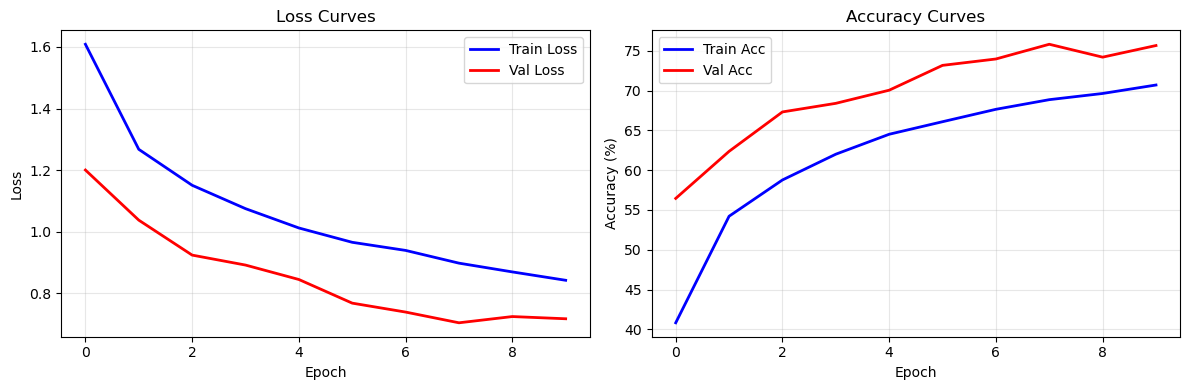


Training Diagnostics:
Final train accuracy: 70.69%
Final val accuracy: 75.65%
Train-val gap: -4.96%

[OK] Gap looks reasonable. Model is learning patterns that generalize.


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves
axes[0].plot(history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(history['train_acc'], 'b-', label='Train Acc', linewidth=2)
axes[1].plot(history['val_acc'], 'r-', label='Val Acc', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')  # Free figure memory

# Diagnostic analysis
train_val_gap = history['train_acc'][-1] - history['val_acc'][-1]
print("\nTraining Diagnostics:")
print(f"Final train accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final val accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Train-val gap: {train_val_gap:.2f}%")

if train_val_gap > 15:
    print("\n[!] Large gap suggests overfitting. Try: more augmentation, dropout, or fewer epochs.")
elif train_val_gap < 5 and history['val_acc'][-1] < 70:
    print("\n[!] Small gap but low accuracy suggests underfitting. Try: larger model or longer training.")
else:
    print("\n[OK] Gap looks reasonable. Model is learning patterns that generalize.")

---

## Part 4: Evaluation and Analysis

Training accuracy doesn't tell the whole story. In this section, we'll dig deeper into model performance using confusion matrices, error analysis, and confidence calibration.

### 4.1 Beyond Accuracy

Our model achieved **75% accuracy**. Is that good?

It depends on context. Accuracy alone can be misleading. Consider:
- A model that predicts "not cancer" 99% of the time is 99% accurate if 99% of cases are healthy
- But it's useless for finding actual cancer cases!
- Similarly, **75% overall accuracy might hide 36% accuracy on cats**

For CIFAR-10 specifically:
- Random guessing = 10% accuracy (1 in 10 classes)
- 75% is a solid baseline for a simple CNN
- State-of-the-art models achieve 99%+ with advanced architectures

**Key Metrics for Deeper Analysis**

| Metric | Question It Answers |
|--------|---------------------|
| **Per-class accuracy** | Which classes is the model good/bad at? |
| **Precision** | Of images predicted as X, how many are actually X? |
| **Recall** | Of all X images, how many did we find? |
| **Confusion Matrix** | What does the model confuse with what? |
| **Confidence** | Does the model know when it's uncertain? |

The following analysis will reveal that our 75% accuracy masks serious problems with animal classification — particularly cats.

In [17]:
def get_all_predictions(model, loader, device):
    """Get predictions and labels for entire dataset."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Get predictions
preds, labels, probs = get_all_predictions(model, test_loader, device)
print(f"Total test samples: {len(labels)}")
print(f"Overall accuracy: {(preds == labels).mean() * 100:.2f}%")

Total test samples: 10000
Overall accuracy: 75.65%


### 4.2 Confusion Matrix

The confusion matrix reveals *where* the model succeeds and fails. Each row represents the true class, each column the predicted class. Diagonal entries are correct predictions; off-diagonal entries are mistakes.

**Interpreting the Per-Class Accuracy**

Looking at our results, a striking pattern emerges:

| Class | Accuracy | Analysis |
|-------|----------|----------|
| **ship** | ~88% | Distinctive features: blue background (water/sky), clear geometric shape |
| **truck** | ~87% | Rectangular, wheels visible, often on roads |
| **automobile** | ~87% | Similar to truck — vehicles are "easy" due to consistent structure |
| **dog** | ~86% | High accuracy but *problematic* — see below |
| **airplane** | ~81% | Usually against sky, distinctive wing shapes |
| **horse** | ~75% | Four-legged animal, but confused with other animals |
| **deer/frog** | ~72% | Mid-range — some distinctive features but overlapping patterns |
| **bird** | ~64% | Small, varied poses, often against complex backgrounds |
| **cat** | ~36% | **Terrible!** — more cats are misclassified than correctly identified |

**Why Are Vehicles Easy?**

Vehicles share structural properties that make them distinctive:
- Geometric shapes (rectangles, circles for wheels)
- Consistent orientations (usually photographed from the side)
- Predictable backgrounds (roads, sky)
- Less variation in appearance compared to animals

**The "Dog" Problem**

Dog has high accuracy (86%), but this hides a serious issue: the model is using "dog" as a **catch-all category** for anything that looks vaguely animal-like. This becomes clear in the error analysis below.

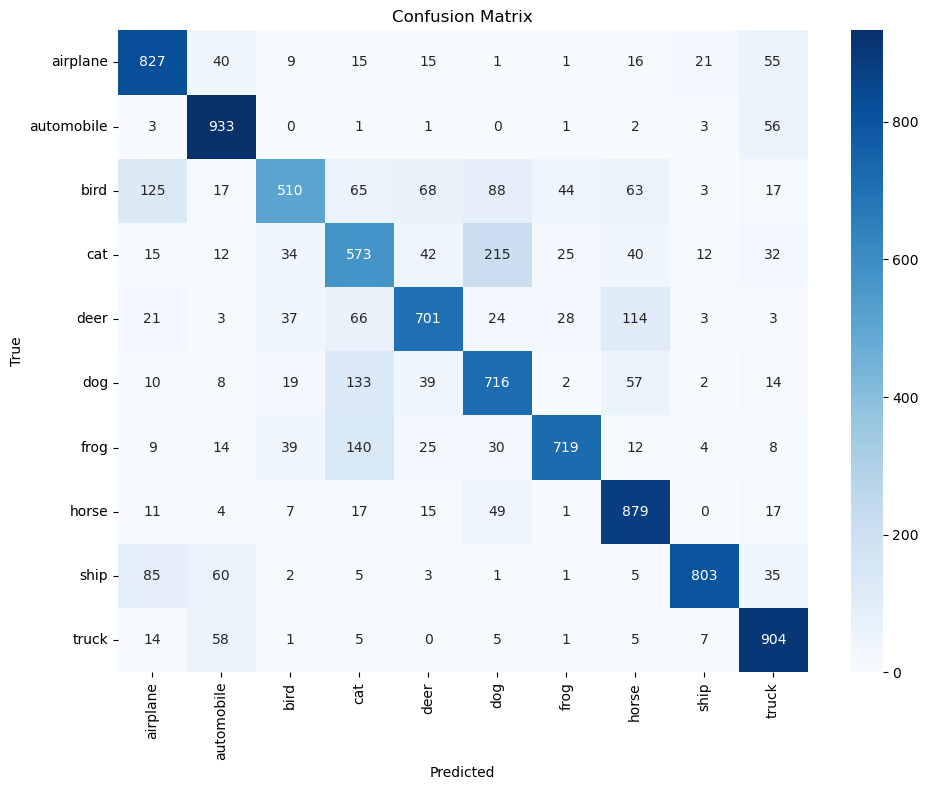


Per-class accuracy:
  airplane    : 82.7%
  automobile  : 93.3%
  bird        : 51.0%
  cat         : 57.3%
  deer        : 70.1%
  dog         : 71.6%
  frog        : 71.9%
  horse       : 87.9%
  ship        : 80.3%
  truck       : 90.4%


In [18]:
# Confusion matrix
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
plt.close('all')  # Free figure memory

# Per-class accuracy
print("\nPer-class accuracy:")
for i, class_name in enumerate(CLASSES):
    class_mask = labels == i
    class_acc = (preds[class_mask] == labels[class_mask]).mean() * 100
    print(f"  {class_name:12s}: {class_acc:.1f}%")

### 4.2.1 Per-Class Accuracy

The confusion matrix shows raw counts, but **per-class accuracy** reveals which classes are hardest:

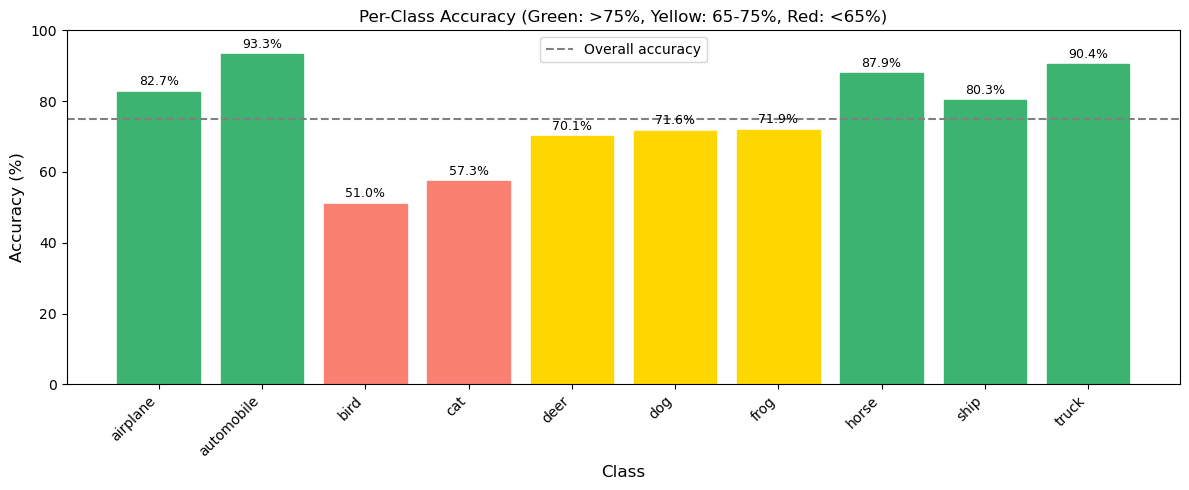


Classes sorted by accuracy:
-----------------------------------
bird        :  51.0% (hard)
cat         :  57.3% (hard)
deer        :  70.1% (medium)
dog         :  71.6% (medium)
frog        :  71.9% (medium)
ship        :  80.3% (easy)
airplane    :  82.7% (easy)
horse       :  87.9% (easy)
truck       :  90.4% (easy)
automobile  :  93.3% (easy)


In [19]:
# Calculate per-class accuracy
per_class_correct = cm.diagonal()
per_class_total = cm.sum(axis=1)
per_class_acc = per_class_correct / per_class_total * 100

# Create a bar chart
fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(CLASSES, per_class_acc, color='steelblue', edgecolor='black')

# Color bars by performance
for bar, acc in zip(bars, per_class_acc):
    if acc < 65:
        bar.set_color('salmon')
    elif acc < 75:
        bar.set_color('gold')
    else:
        bar.set_color('mediumseagreen')

ax.axhline(y=75, color='gray', linestyle='--', label='Overall accuracy')
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_xlabel('Class', fontsize=12)
ax.set_title('Per-Class Accuracy (Green: >75%, Yellow: 65-75%, Red: <65%)', fontsize=12)
ax.set_ylim(0, 100)
ax.legend()

# Add value labels on bars
for bar, acc in zip(bars, per_class_acc):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close('all')  # Free figure memory

# Print sorted by accuracy
print("\nClasses sorted by accuracy:")
print("-" * 35)
sorted_idx = np.argsort(per_class_acc)
for idx in sorted_idx:
    acc = per_class_acc[idx]
    status = "easy" if acc > 80 else ("hard" if acc < 65 else "medium")
    print(f"{CLASSES[idx]:12s}: {acc:5.1f}% ({status})")

### 4.3 Error Analysis

Looking at *which* images the model gets wrong is often more valuable than aggregate metrics.

**The Dog Attractor Problem**

The error analysis reveals a striking pattern: **"dog" is absorbing errors from almost every animal class**:

- Cat → Dog: **45%** of cat errors (massive!)
- Horse → Dog: 14% of horse errors
- Bird → Dog: 13% of bird errors  
- Deer → Dog: 7% of deer errors
- Frog → Dog: 7% of frog errors

This isn't a coincidence. Here's what's happening:

1. **Class imbalance in feature space**: Dogs in CIFAR-10 appear in highly varied poses, backgrounds, and lighting conditions. The model learns a very *broad* representation of "dog" that overlaps with other animals.

2. **Shared animal features**: Fur texture, four legs, eyes, ears — these features are common across mammals. At 32×32 resolution, the subtle differences (cat ears vs dog ears, cat snout vs dog snout) are just a few pixels.

3. **The cat problem specifically**: Cats and dogs share the most features (furry, similar size, similar poses — sitting, lying down, facing camera). The model can't reliably distinguish them because the discriminative features are too fine-grained for this resolution.

**Why Does This Matter?**

This analysis reveals that our 75% accuracy hides significant weaknesses:
- The model is essentially **guessing** on cats (36% accuracy is barely above random for a 10-class problem)
- High dog accuracy is partly **inflated** by false positives from other classes
- Vehicle classes are carrying the overall accuracy

**What Could Help?**

- Higher resolution images (more pixels = more detail for fine distinctions)
- More sophisticated architectures (attention mechanisms to focus on discriminative regions)
- Data augmentation specifically targeting animal classes
- Larger training sets with more varied examples

In [20]:
# Find most confused class pairs
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

mistakes = []
for i in range(10):
    for j in range(10):
        if i != j:
            mistakes.append((CLASSES[i], CLASSES[j], cm[i, j], cm_normalized[i, j]))

mistakes.sort(key=lambda x: x[2], reverse=True)

print("Top 10 most common mistakes:")
print("-" * 50)
for true_class, pred_class, count, rate in mistakes[:10]:
    print(f"{true_class:12s} -> {pred_class:12s}: {count:4d} ({rate*100:.1f}%)")

Top 10 most common mistakes:
--------------------------------------------------
cat          -> dog         :  215 (21.5%)
frog         -> cat         :  140 (14.0%)
dog          -> cat         :  133 (13.3%)
bird         -> airplane    :  125 (12.5%)
deer         -> horse       :  114 (11.4%)
bird         -> dog         :   88 (8.8%)
ship         -> airplane    :   85 (8.5%)
bird         -> deer        :   68 (6.8%)
deer         -> cat         :   66 (6.6%)
bird         -> cat         :   65 (6.5%)


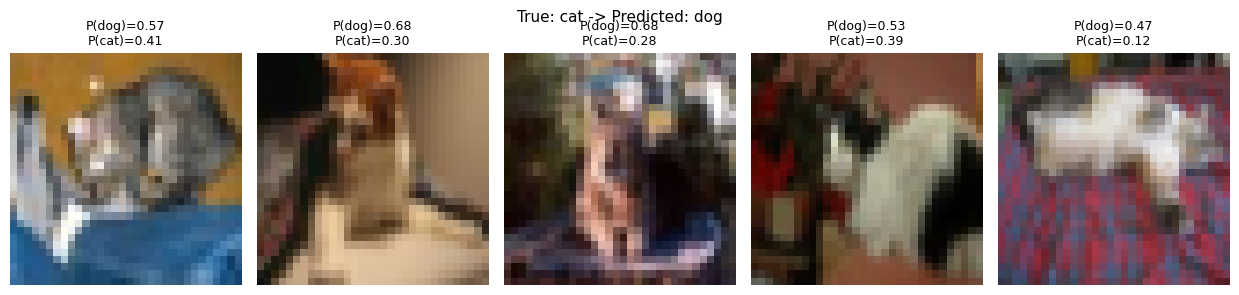

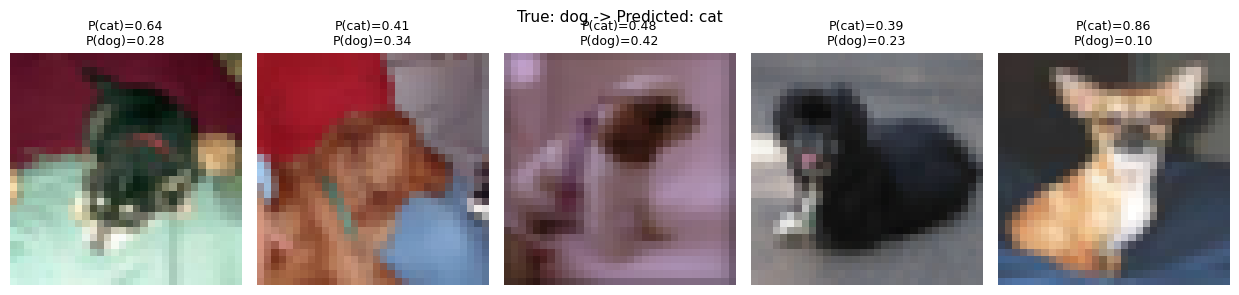

In [21]:
def show_mistakes(true_class, pred_class, n_examples=5):
    """Show examples where true_class was predicted as pred_class."""
    true_idx = CLASSES.index(true_class)
    pred_idx = CLASSES.index(pred_class)
    
    mistake_indices = np.where((labels == true_idx) & (preds == pred_idx))[0]
    
    if len(mistake_indices) == 0:
        print(f"No examples of {true_class} -> {pred_class}")
        return
    
    n_show = min(n_examples, len(mistake_indices))
    fig, axes = plt.subplots(1, n_show, figsize=(2.5 * n_show, 3))
    if n_show == 1:
        axes = [axes]
    
    for idx, ax in zip(mistake_indices[:n_show], axes):
        img, _ = test_dataset[idx]
        img = img * torch.tensor([0.247, 0.243, 0.262]).view(3,1,1) + torch.tensor([0.491, 0.482, 0.447]).view(3,1,1)
        ax.imshow(img.permute(1, 2, 0).clip(0, 1))
        ax.set_title(f"P({pred_class})={probs[idx, pred_idx]:.2f}\nP({true_class})={probs[idx, true_idx]:.2f}", fontsize=9)
        ax.axis('off')
    
    plt.suptitle(f"True: {true_class} -> Predicted: {pred_class}", fontsize=11)
    plt.tight_layout()
    plt.show()
    plt.close('all')  # Free figure memory

# Show examples of top confusions
show_mistakes('cat', 'dog')
show_mistakes('dog', 'cat')

# Analyze prediction confidence
correct_mask = preds == labels
correct_confidences = probs[np.arange(len(preds)), preds][correct_mask]
wrong_confidences = probs[np.arange(len(preds)), preds][~correct_mask]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of confidences
axes[0].hist(correct_confidences, bins=30, alpha=0.7, label=f'Correct (n={len(correct_confidences)})', density=True)
axes[0].hist(wrong_confidences, bins=30, alpha=0.7, label=f'Wrong (n={len(wrong_confidences)})', density=True)
axes[0].set_xlabel('Confidence (predicted probability)')
axes[0].set_ylabel('Density')
axes[0].set_title('Confidence Distribution')
axes[0].legend()

# Accuracy vs confidence
confidence_bins = np.linspace(0, 1, 11)
bin_accs = []
bin_counts = []

max_conf = probs.max(axis=1)
for i in range(len(confidence_bins) - 1):
    mask = (max_conf >= confidence_bins[i]) & (max_conf < confidence_bins[i+1])
    if mask.sum() > 0:
        bin_accs.append((preds[mask] == labels[mask]).mean() * 100)
        bin_counts.append(mask.sum())
    else:
        bin_accs.append(0)
        bin_counts.append(0)

bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
axes[1].bar(bin_centers, bin_accs, width=0.08, alpha=0.7, label='Accuracy')
axes[1].plot([0, 1], [0, 100], 'r--', label='Perfect calibration')
axes[1].set_xlabel('Confidence')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Calibration: Accuracy vs Confidence')
axes[1].legend()

plt.tight_layout()
plt.show()
plt.close('all')

print("\nConfidence Analysis:")
print(f"Average confidence on correct predictions: {correct_confidences.mean():.3f}")
print(f"Average confidence on wrong predictions: {wrong_confidences.mean():.3f}")

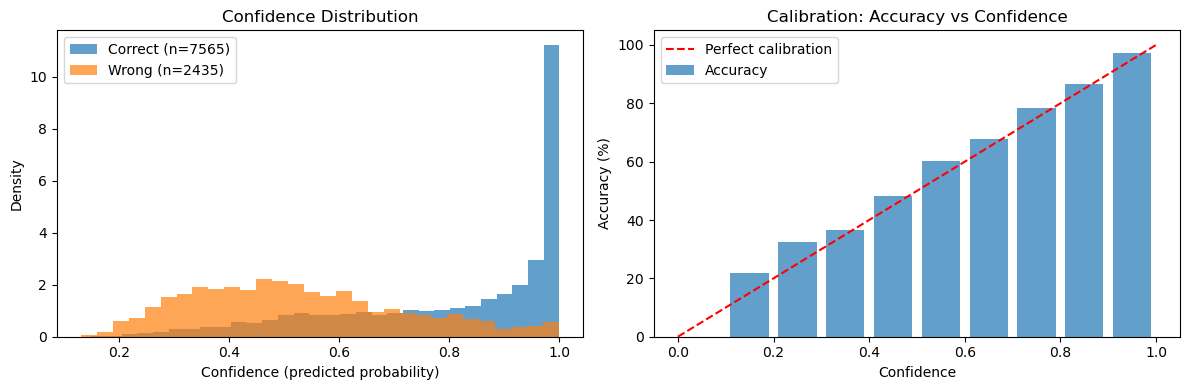


Confidence Analysis:
Average confidence on correct predictions: 0.806
Average confidence on wrong predictions: 0.523


In [22]:
# Analyze prediction confidence
correct_mask = preds == labels
correct_confidences = probs[np.arange(len(preds)), preds][correct_mask]
wrong_confidences = probs[np.arange(len(preds)), preds][~correct_mask]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of confidences
axes[0].hist(correct_confidences, bins=30, alpha=0.7, label=f'Correct (n={len(correct_confidences)})', density=True)
axes[0].hist(wrong_confidences, bins=30, alpha=0.7, label=f'Wrong (n={len(wrong_confidences)})', density=True)
axes[0].set_xlabel('Confidence (predicted probability)')
axes[0].set_ylabel('Density')
axes[0].set_title('Confidence Distribution')
axes[0].legend()

# Accuracy vs confidence
confidence_bins = np.linspace(0, 1, 11)
bin_accs = []
bin_counts = []

max_conf = probs.max(axis=1)
for i in range(len(confidence_bins) - 1):
    mask = (max_conf >= confidence_bins[i]) & (max_conf < confidence_bins[i+1])
    if mask.sum() > 0:
        bin_accs.append((preds[mask] == labels[mask]).mean() * 100)
        bin_counts.append(mask.sum())
    else:
        bin_accs.append(0)
        bin_counts.append(0)

bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
axes[1].bar(bin_centers, bin_accs, width=0.08, alpha=0.7, label='Accuracy')
axes[1].plot([0, 1], [0, 100], 'r--', label='Perfect calibration')
axes[1].set_xlabel('Confidence')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Calibration: Accuracy vs Confidence')
axes[1].legend()

plt.tight_layout()
plt.show()
plt.close(fig)  # Explicitly close this figure

print("\nConfidence Analysis:")
print(f"Average confidence on correct predictions: {correct_confidences.mean():.3f}")
print(f"Average confidence on wrong predictions: {wrong_confidences.mean():.3f}")

# Aggressive cleanup before t-SNE
import gc
plt.close('all')
del correct_confidences, wrong_confidences, bin_accs, bin_counts, max_conf, fig, axes
gc.collect()
if 'torch' in dir() and hasattr(torch, 'cuda') and torch.cuda.is_available():
    torch.cuda.empty_cache()

---

## Part 5: Transfer Learning

Training from scratch works, but there's a better way. Transfer learning lets us leverage models that have already learned to "see" from millions of images.

### 5.1 Why Transfer Learning?

Training a CNN from scratch requires:
- Lots of labeled data (thousands to millions of images)
- Significant compute time
- Risk of overfitting on small datasets

**Transfer learning** leverages models pretrained on large datasets (like ImageNet with 1M+ images, 1000 classes).

**Key insight**: Early CNN layers learn universal features (edges, textures, shapes) that transfer across tasks. Only the final classifier needs task-specific training.

**ResNet-18 Architecture**

We'll use ResNet-18, a powerful yet efficient architecture:

```
Input Image (224×224×3)
        │
┌───────▼───────┐
│   Conv Layer  │  7×7 conv, 64 filters, stride 2
│   + MaxPool   │  Output: 56×56×64
└───────┬───────┘
        │
┌───────▼───────┐
│  Residual     │  Layer 1: 2 blocks, 64 filters
│  Blocks ×2    │  Output: 56×56×64
└───────┬───────┘
        │
┌───────▼───────┐
│  Residual     │  Layer 2: 2 blocks, 128 filters
│  Blocks ×2    │  Output: 28×28×128
└───────┬───────┘
        │
┌───────▼───────┐
│  Residual     │  Layer 3: 2 blocks, 256 filters
│  Blocks ×2    │  Output: 14×14×256
└───────┬───────┘
        │
┌───────▼───────┐
│  Residual     │  Layer 4: 2 blocks, 512 filters
│  Blocks ×2    │  Output: 7×7×512
└───────┬───────┘
        │
┌───────▼───────┐
│  Global Avg   │  Collapse spatial dimensions
│  Pooling      │  Output: 512-dim vector
└───────┬───────┘
        │
┌───────▼───────┐
│  Classifier   │  ← We replace this! (512 → 10)
│  (FC Layer)   │  
└───────┬───────┘
        │
     Predictions
```

**The Skip Connection ("Residual" in ResNet)**

Each residual block adds its input to its output: `output = F(x) + x`

This allows gradients to flow directly backward, enabling training of very deep networks.

**Our Approach: Feature Extraction**

We'll use the pretrained ResNet as a fixed feature extractor:

1. **Load pretrained ResNet-18** — Trained on ImageNet (1.2M images)
2. **Remove the classifier** — Strip off the final 1000-class layer
3. **Freeze all weights** — No backprop through convolutions
4. **Add new classifier** — A single linear layer: 512 → 10 classes
5. **Train only the classifier** — Much faster, fewer parameters

In [23]:
# Load pretrained ResNet-18 and remove the classifier head
resnet = models.resnet18(weights='IMAGENET1K_V1')

# ResNet structure: conv1 → bn1 → relu → maxpool → layer1-4 → avgpool → fc
# We keep everything except 'fc' to get 512-dimensional features
feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
feature_extractor.eval()  # Always in eval mode (frozen)
feature_extractor = feature_extractor.to(device)

# Verify output shape
dummy = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    out = feature_extractor(dummy)
print(f"Feature extractor output shape: {out.shape}")
print(f"Each image becomes a {out.numel()}-dimensional feature vector")
print(f"\nThese 512 numbers encode what ResNet 'sees' in the image:"
      f"\n  textures, shapes, colors, patterns — learned from 1M+ ImageNet images")

Feature extractor output shape: torch.Size([1, 512, 1, 1])
Each image becomes a 512-dimensional feature vector

These 512 numbers encode what ResNet 'sees' in the image:
  textures, shapes, colors, patterns — learned from 1M+ ImageNet images


### 5.2 Extract Features (One-Time Cost)

Now we run all 60,000 images through the frozen backbone and cache the 512-dimensional feature vectors. This is the slow part (~5 min on CPU), but we only do it **once**.

**What's happening under the hood:**
- Each 32×32 CIFAR image is resized to 224×224 (ImageNet size)
- The image passes through ResNet's conv layers, pooling layers, and residual blocks
- The final average pooling produces a 512-dimensional vector
- This vector captures "what ResNet sees" — textures, shapes, object parts

After extraction, we have:
- `train_features`: 50,000 × 512 tensor (~100 MB)
- `test_features`: 10,000 × 512 tensor (~20 MB)

These cached features make classifier training instant.

In [24]:
# Standard ImageNet preprocessing
transfer_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Load CIFAR-10 with ImageNet preprocessing
transfer_train = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transfer_transform)
transfer_test = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transfer_transform)

# Data loaders for feature extraction
extract_loader_train = DataLoader(transfer_train, batch_size=64, shuffle=False, num_workers=0)
extract_loader_test = DataLoader(transfer_test, batch_size=64, shuffle=False, num_workers=0)

def extract_features(loader, model, device):
    """Run all images through the model and return features + labels."""
    all_features = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting"):
            features = model(images.to(device))
            features = features.squeeze()  # (B, 512, 1, 1) → (B, 512)
            all_features.append(features.cpu())
            all_labels.append(labels)
    
    return torch.cat(all_features), torch.cat(all_labels)

# Extract features (this takes a few minutes on CPU)
print("Extracting training set features...")
train_features, train_labels = extract_features(extract_loader_train, feature_extractor, device)

print("Extracting test set features...")
test_features, test_labels = extract_features(extract_loader_test, feature_extractor, device)

print(f"\nTrain features: {train_features.shape}")
print(f"Test features: {test_features.shape}")
print(f"\nFeatures cached! Now classifier training will be instant.")

Extracting training set features...


Extracting:   0%|          | 0/782 [00:00<?, ?it/s]

Extracting test set features...


Extracting:   0%|          | 0/157 [00:00<?, ?it/s]


Train features: torch.Size([50000, 512])
Test features: torch.Size([10000, 512])

Features cached! Now classifier training will be instant.


In [25]:
# Create a simple linear classifier
classifier = nn.Linear(512, 10).to(device)

# Create datasets from cached features
from torch.utils.data import TensorDataset
train_dataset_cached = TensorDataset(train_features, train_labels)
test_dataset_cached = TensorDataset(test_features, test_labels)

train_loader_cached = DataLoader(train_dataset_cached, batch_size=256, shuffle=True)
test_loader_cached = DataLoader(test_dataset_cached, batch_size=256, shuffle=False)

# Training setup
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

TRANSFER_EPOCHS = 10
transfer_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

trainable_params = sum(p.numel() for p in classifier.parameters())
print(f"Training linear classifier on cached features...")
print(f"Trainable parameters: {trainable_params:,} (just the classifier!)")
print("-" * 60)

for epoch in range(TRANSFER_EPOCHS):
    epoch_start = time.time()
    
    # Training
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for features, labels in train_loader_cached:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * features.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / total
    train_acc = 100. * correct / total
    
    # Validation
    classifier.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for features, labels in test_loader_cached:
            features, labels = features.to(device), labels.to(device)
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * features.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = running_loss / total
    val_acc = 100. * correct / total
    
    transfer_history['train_loss'].append(train_loss)
    transfer_history['train_acc'].append(train_acc)
    transfer_history['val_loss'].append(val_loss)
    transfer_history['val_acc'].append(val_acc)
    
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1:2d}/{TRANSFER_EPOCHS} ({epoch_time:.3f}s) | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

print("-" * 60)
print(f"Best validation accuracy: {max(transfer_history['val_acc']):.2f}%")
print(f"\nNotice how fast each epoch is — just matrix multiplication on 512-dim vectors!")

Training linear classifier on cached features...
Trainable parameters: 5,130 (just the classifier!)
------------------------------------------------------------
Epoch  1/10 (0.422s) | Train Loss: 0.8357, Acc: 75.34% | Val Loss: 0.5389, Acc: 82.87%
Epoch  2/10 (0.378s) | Train Loss: 0.4855, Acc: 84.39% | Val Loss: 0.4676, Acc: 84.28%
Epoch  3/10 (0.374s) | Train Loss: 0.4346, Acc: 85.63% | Val Loss: 0.4408, Acc: 85.04%
Epoch  4/10 (0.374s) | Train Loss: 0.4107, Acc: 86.26% | Val Loss: 0.4267, Acc: 85.07%
Epoch  5/10 (0.416s) | Train Loss: 0.3966, Acc: 86.54% | Val Loss: 0.4157, Acc: 85.60%
Epoch  6/10 (0.370s) | Train Loss: 0.3855, Acc: 87.06% | Val Loss: 0.4126, Acc: 85.60%
Epoch  7/10 (0.370s) | Train Loss: 0.3783, Acc: 87.05% | Val Loss: 0.4100, Acc: 85.62%
Epoch  8/10 (0.371s) | Train Loss: 0.3722, Acc: 87.23% | Val Loss: 0.4080, Acc: 85.74%
Epoch  9/10 (0.535s) | Train Loss: 0.3660, Acc: 87.54% | Val Loss: 0.4014, Acc: 85.93%
Epoch 10/10 (0.390s) | Train Loss: 0.3622, Acc: 87.53% |

### 5.3 Comparison: Scratch vs. Transfer Learning

Now let's compare our two approaches quantitatively. The comparison code below extracts the actual results from your training runs:

COMPARISON: Training From Scratch vs. Transfer Learning

┌─────────────────────┬──────────────────┬────────────────────┐
│ Metric              │ From Scratch     │ Transfer Learning  │
├─────────────────────┼──────────────────┼────────────────────┤
│ Best Val Accuracy   │          75.81% │            85.98% │
│ Trainable Params    │        620,810 │            5,130 │
│ Architecture        │ SimpleCNN (3 conv)│ ResNet18 + Linear │
│ Training Epochs     │             10 │               10 │
└─────────────────────┴──────────────────┴────────────────────┘

Key Takeaways:
  • Accuracy improvement: +10.17%
  • Parameter reduction: 121× fewer trainable params
  • Transfer learning achieves better results with far less training!



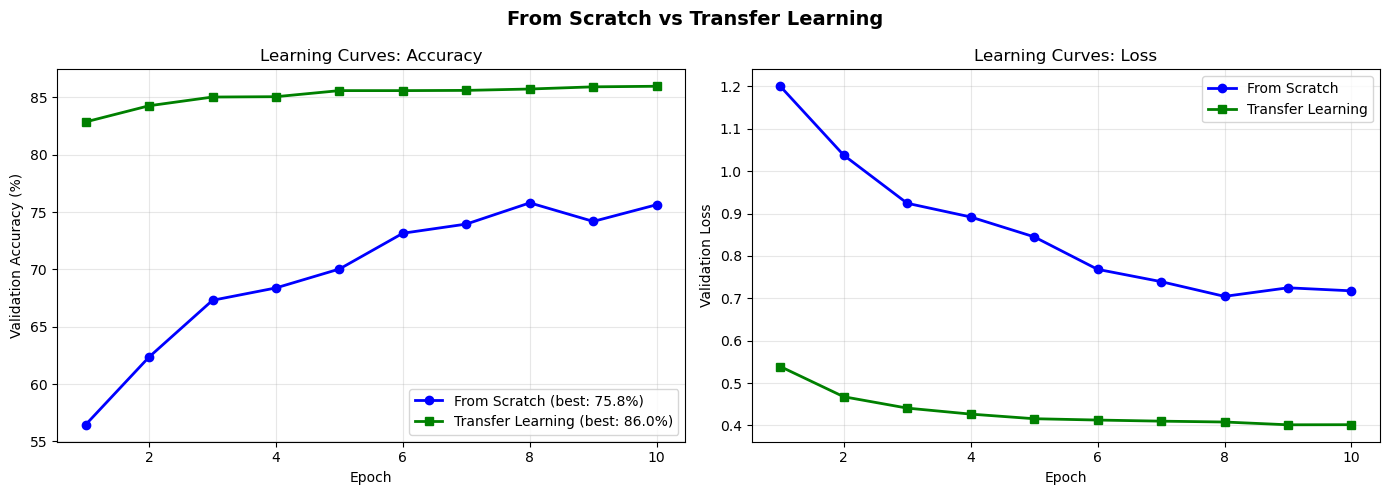


Why Is Feature Extraction So Effective?

1. BETTER FEATURES
   ResNet learned from 1.2 million ImageNet images across 1000 classes.
   It "knows" about fur, wheels, wings, eyes — concepts useful for CIFAR-10.
   Our SimpleCNN only learned from 50K CIFAR images.

2. MORE CAPACITY
   ResNet-18 has 11M parameters encoding visual knowledge. Even though
   we only train 5K, the frozen 11M are doing the heavy lifting.

3. REGULARIZATION FOR FREE
   We can't overfit the feature extractor — it's frozen! This acts as
   strong regularization, preventing overfitting on small datasets.

4. PROVEN ARCHITECTURE
   ResNet's architecture (skip connections, batch norm, etc.) is
   battle-tested on massive datasets. Our SimpleCNN is a guess.



In [26]:
# Compare the two approaches with actual numbers from training
print("=" * 70)
print("COMPARISON: Training From Scratch vs. Transfer Learning")
print("=" * 70)

# Get actual numbers from training
scratch_best = max(history['val_acc']) if history.get('val_acc') else 0
transfer_best = max(transfer_history['val_acc']) if transfer_history.get('val_acc') else 0

scratch_params = sum(p.numel() for p in SimpleCNN().parameters())
transfer_params = 512 * 10 + 10  # Linear layer weights + bias

improvement = transfer_best - scratch_best

# Print comparison table
print(f"""
┌─────────────────────┬──────────────────┬────────────────────┐
│ Metric              │ From Scratch     │ Transfer Learning  │
├─────────────────────┼──────────────────┼────────────────────┤
│ Best Val Accuracy   │ {scratch_best:>14.2f}% │ {transfer_best:>16.2f}% │
│ Trainable Params    │ {scratch_params:>14,} │ {transfer_params:>16,} │
│ Architecture        │ SimpleCNN (3 conv)│ ResNet18 + Linear │
│ Training Epochs     │ {NUM_EPOCHS:>14} │ {TRANSFER_EPOCHS:>16} │
└─────────────────────┴──────────────────┴────────────────────┘

Key Takeaways:
  • Accuracy improvement: {improvement:+.2f}%
  • Parameter reduction: {scratch_params/transfer_params:.0f}× fewer trainable params
  • Transfer learning achieves better results with far less training!
""")

# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy comparison
epochs_scratch = range(1, len(history['val_acc']) + 1)
epochs_transfer = range(1, len(transfer_history['val_acc']) + 1)

axes[0].plot(epochs_scratch, history['val_acc'], 'b-o', label=f'From Scratch (best: {scratch_best:.1f}%)', linewidth=2)
axes[0].plot(epochs_transfer, transfer_history['val_acc'], 'g-s', label=f'Transfer Learning (best: {transfer_best:.1f}%)', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy (%)')
axes[0].set_title('Learning Curves: Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss comparison  
axes[1].plot(epochs_scratch, history['val_loss'], 'b-o', label='From Scratch', linewidth=2)
axes[1].plot(epochs_transfer, transfer_history['val_loss'], 'g-s', label='Transfer Learning', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Learning Curves: Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('From Scratch vs Transfer Learning', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Why transfer learning works so well
print("""
Why Is Feature Extraction So Effective?

1. BETTER FEATURES
   ResNet learned from 1.2 million ImageNet images across 1000 classes.
   It "knows" about fur, wheels, wings, eyes — concepts useful for CIFAR-10.
   Our SimpleCNN only learned from 50K CIFAR images.

2. MORE CAPACITY
   ResNet-18 has 11M parameters encoding visual knowledge. Even though
   we only train 5K, the frozen 11M are doing the heavy lifting.

3. REGULARIZATION FOR FREE
   We can't overfit the feature extractor — it's frozen! This acts as
   strong regularization, preventing overfitting on small datasets.

4. PROVEN ARCHITECTURE
   ResNet's architecture (skip connections, batch norm, etc.) is
   battle-tested on massive datasets. Our SimpleCNN is a guess.
""")

### 5.4 When to Use Transfer Learning?

**Use transfer learning when:**
- Your dataset is small to medium (< 100k images)
- Your images are similar to ImageNet (natural photos)
- You want fast iteration and prototyping
- Compute resources are limited

**Consider training from scratch when:**
- Your domain is very different (X-rays, satellite images, spectrograms)
- You have millions of labeled images
- You need a custom architecture for specific constraints

**Beyond Feature Extraction**

We used the simplest approach: frozen backbone + linear classifier. For better accuracy (with more compute), you can:

| Approach | What's Trainable | Typical Use Case |
|----------|------------------|------------------|
| **Feature extraction** | Only classifier | Small data, fast prototyping |
| **Fine-tune last layers** | Last block + classifier | Medium data |
| **Full fine-tuning** | Everything (small LR) | Large data, maximum accuracy |

For most practical applications, feature extraction is the right starting point — it's fast, simple, and surprisingly effective.

---

## Congratulations!

You've completed the Image Classification tutorial. You now understand:

- How images are represented as tensors
- How CNNs learn hierarchical features through convolution
- How to train and evaluate a classifier
- How transfer learning accelerates development

## Key Takeaways

1. **Normalization matters** — Always normalize inputs to zero mean, unit variance
2. **Start simple** — A small CNN can achieve 75%+ on CIFAR-10
3. **Watch your curves** — Training curves reveal overfitting, underfitting, and bugs
4. **Analyze errors** — Looking at mistakes teaches more than aggregate metrics
5. **Transfer learning is powerful** — Pretrained features beat custom CNNs with minimal effort

## Common Pitfalls

| Problem | Symptom | Solution |
|---------|---------|----------|
| Forgot to normalize | Poor convergence, NaN loss | Add normalization to transforms |
| Wrong input shape | Runtime error | Check tensor shapes at each step |
| Learning rate too high | Loss explodes or oscillates | Reduce by 10x |
| Overfitting | Train acc >> val acc | Add augmentation, dropout |
| Forgot `model.eval()` | Inconsistent val results | Always set mode before eval |

---

## Next Steps: Build Your Own Project

Now it's time to apply what you've learned. Open `project_template.ipynb` in this folder and build your own image classifier:

**Project Ideas:**
- **Different dataset**: Try Fashion-MNIST, SVHN, or your own images
- **Fine-tuning**: Unfreeze ResNet's last layers and compare to feature extraction
- **Architecture experiments**: Modify SimpleCNN — add layers, change channels, try different activations
- **Advanced augmentation**: Add CutOut, MixUp, or AutoAugment
- **Ensemble methods**: Combine predictions from multiple models

The template provides the scaffolding — you bring the creativity. Good luck!

## References

1. Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). *ImageNet Classification with Deep Convolutional Neural Networks*. NeurIPS.
2. He, K., Zhang, X., Ren, S., & Sun, J. (2016). *Deep Residual Learning for Image Recognition*. CVPR.
3. Krizhevsky, A. (2009). *Learning Multiple Layers of Features from Tiny Images*. (CIFAR-10 paper)